Here is the Kernel for get start with image masking. We mask Carvana Image data set with U-net model and implement with Keras and Tensorslow

# Import Global

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from skimage import io, transform
import cv2
import tensorflow as tf

Let see the files we have

In [2]:
import os
print(os.listdir("../input"))

['test', 'train_masks.csv', 'train_masks', 'metadata.csv', 'sample_submission.csv', 'train']


# Global Varaible 

In [3]:
FAST_RUN=False
FAST_PREDICT=True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
CHANNEL=3
input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNEL)
mask_shape=(IMAGE_WIDTH, IMAGE_HEIGHT)
image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size=10
epochs=3

# Read Data

In [4]:
metadata = pd.read_csv("../input/metadata.csv")
train_masks = pd.read_csv("../input/train_masks.csv")
testdata = pd.read_csv("../input/sample_submission.csv")

In [5]:
print(train_masks.shape)
print(testdata.shape)

(5088, 2)
(100064, 2)


Fast run for development

In [6]:
if FAST_RUN:
    epochs=1
    train_masks = train_masks.sample(1000).reset_index()

if FAST_PREDICT: 
    testdata = testdata.sample(batch_size).reset_index()

View test data frame

In [7]:
testdata.head()

,index,img,rle_mask
0,80388,cc1e0a1addd5_05.jpg,1 1
1,61423,9de472a87a27_16.jpg,1 1
2,63883,a482ea271a5c_12.jpg,1 1
3,46442,76ad468a9740_11.jpg,1 1
4,4979,0dcdcfdaf0d3_04.jpg,1 1


View meta data frame

In [8]:
metadata.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


View masks data frame

In [9]:
train_masks.head()

,index,img,rle_mask
0,1757,4e7bc95552ed_14.jpg,585590 23 585830 48 587505 35 587702 127 58942...
1,2338,6c0cd487abcd_03.jpg,984931 115 986819 167 988714 205 990617 235 99...
2,1647,4b74275babf7_16.jpg,852608 1 854526 2 856445 1 858363 2 860281 2 8...
3,1897,56023a17481b_10.jpg,459665 2 461583 2 463502 1 465420 1 467338 1 4...
4,2360,6c3470c34408_09.jpg,599300 88 601200 129 603105 160 605010 189 606...


Genarate Mask filename

In [10]:
filenames = train_masks.img.str.split(".")
maskfilenames = filenames.str[0] + "_mask.gif"
train_masks['img_mask'] = maskfilenames
train_masks['angle'] = filenames.str[0].str.split("_").str[1].astype(int)
train_masks.head()

,index,img,rle_mask,img_mask,angle
0,1757,4e7bc95552ed_14.jpg,585590 23 585830 48 587505 35 587702 127 58942...,4e7bc95552ed_14_mask.gif,14
1,2338,6c0cd487abcd_03.jpg,984931 115 986819 167 988714 205 990617 235 99...,6c0cd487abcd_03_mask.gif,3
2,1647,4b74275babf7_16.jpg,852608 1 854526 2 856445 1 858363 2 860281 2 8...,4b74275babf7_16_mask.gif,16
3,1897,56023a17481b_10.jpg,459665 2 461583 2 463502 1 465420 1 467338 1 4...,56023a17481b_10_mask.gif,10
4,2360,6c3470c34408_09.jpg,599300 88 601200 129 603105 160 605010 189 606...,6c3470c34408_09_mask.gif,9


View Images

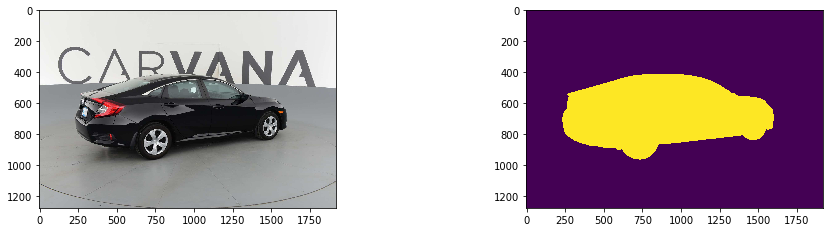

In [11]:
sample = train_masks.sample()
fig=plt.figure(figsize=(16, 8))
for index, s in sample.iterrows():
    original_image = io.imread('../input/train/'+s.img)
    masked_image = io.imread('../input/train_masks/'+s.img_mask)
    plt.subplot(2, 2, 1)
    plt.imshow(original_image)
    plt.subplot(2, 2, 2)
    plt.imshow(masked_image)

# Image Generator

Shift Image

In [12]:
from skimage.transform import AffineTransform, warp
def shift(image, translation_matrix):
    transformer = AffineTransform(translation=translation_matrix)
    return warp(image, transformer, mode='wrap', preserve_range=True)

**Transform Image**

Shift, Flip

In [13]:
def tranform_image(original_image, mask_image):
    image = original_image
    mask = mask_image
    
    isHorizontalFlip = np.random.random() < 0.5
    isShift = np.random.random() < 0.5

    if isShift:
        translation_matrix = np.random.random_integers(-10, 10), np.random.random_integers(-10, 10)
        image = shift(image, translation_matrix)
        mask = shift(mask, translation_matrix)

    if isHorizontalFlip:
        image = image[:, ::-1]
        mask = mask[:, ::-1]
        
    image = image / 255.0
    mask = mask / 255.0
    
    return image, mask

Define Image Generator

In [14]:
def data_gen_small(data_dir, mask_dir, df_data, precess_batch_size, original_image_shape, mask_image_shape):
    while True:
        for k, ix in df_data.groupby(np.arange(len(df_data))//precess_batch_size):
            imgs = []
            labels = []
            for index, row in ix.iterrows():
                # images
                original_img = io.imread(data_dir + row.img)
                resized_img = transform.resize(original_img, image_size, mode='constant')
                # masks
                original_mask = io.imread(mask_dir + row.img_mask, as_gray=True)
                resized_mask = transform.resize(original_mask, image_size, mode='constant')
                
                image, mask = tranform_image(resized_img, resized_mask)
                
                imgs.append(image)
                labels.append(np.expand_dims(mask, axis=2))
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            yield imgs, labels

Create Generator

In [15]:
train_gen = data_gen_small("../input/train/", "../input/train_masks/", train_masks, batch_size, input_shape, mask_shape)

See how our generator work

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  if __name__ == '__main__':


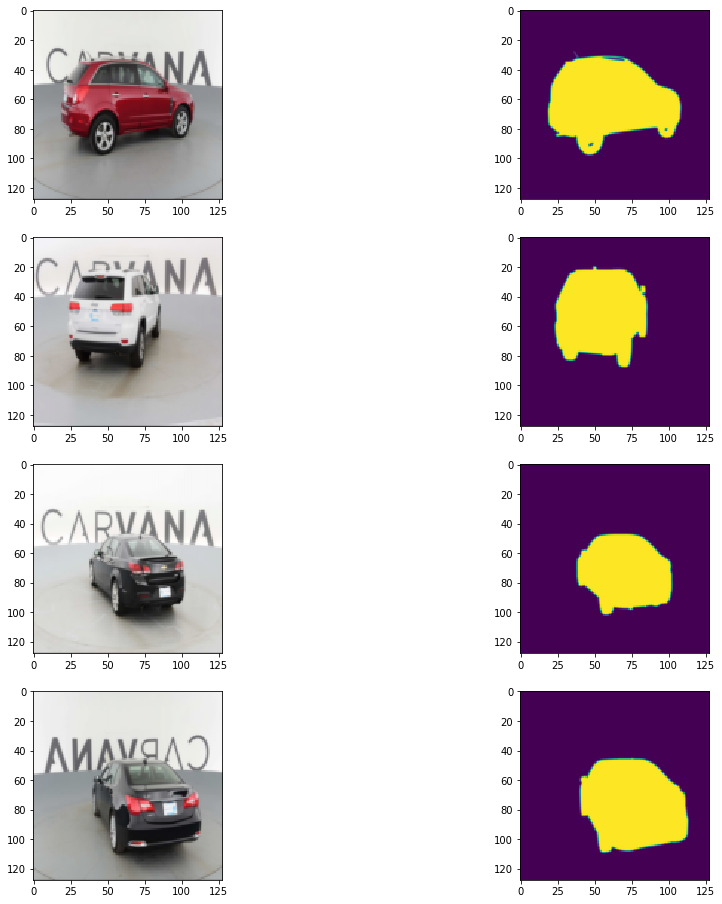

In [26]:
fig=plt.figure(figsize=(16, 16))
for i in [1, 2, 3, 4]:
    img, msk = next(train_gen)
    plt.subplot(4, 2, i*2-1)
    plt.imshow(img[0]*255.0)
    plt.subplot(4, 2, i*2)
    plt.imshow(msk[0].reshape(128, 128))
    

# Model

we use U-Net model to do image masking

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization

inputs = Input(shape=input_shape)
# 128

down1 = Conv2D(64, (3, 3), padding='same')(inputs)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1 = Conv2D(64, (3, 3), padding='same')(down1)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
# 64

down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2 = Conv2D(128, (3, 3), padding='same')(down2)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
# 32

down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3 = Conv2D(256, (3, 3), padding='same')(down3)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
# 16

down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4 = Conv2D(512, (3, 3), padding='same')(down4)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
# 8

center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Conv2D(1024, (3, 3), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)
# center

up4 = UpSampling2D((2, 2))(center)
up4 = concatenate([down4, up4], axis=3)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
# 16

up3 = UpSampling2D((2, 2))(up4)
up3 = concatenate([down3, up3], axis=3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
# 32

up2 = UpSampling2D((2, 2))(up3)
up2 = concatenate([down2, up2], axis=3)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
# 64

up1 = UpSampling2D((2, 2))(up2)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
# 128

outputs = Conv2D(1, (1, 1), activation='sigmoid')(up1)

model = Model(inputs=inputs, outputs=outputs)


Instructions for updating:
Colocations handled automatically by placer.


Compile model

In [ ]:
optimizer = tf.train.RMSPropOptimizer(0.0001)

In [18]:
model.compile(
    optimizer=optimizer, 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

# Train Model

In [19]:
steps_per_epoch=np.ceil(float(len(train_masks)) / float(batch_size)).astype(int)
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=steps_per_epoch,
    epochs=epochs
)

Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  if __name__ == '__main__':


100/100 [==============================] - 728s 7s/step - loss: 2.1830 - acc: 0.7344


# Save Model

In [20]:
model.save("model.h5")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  if __name__ == '__main__':


# Test Generator

Define test generator

In [21]:
def test_gen_small(data_dir, df_data, precess_batch_size, original_image_shape):
    while True:
        for k, ix in df_data.groupby(np.arange(len(df_data))//precess_batch_size):
            imgs = []
            labels = []
            for index, row in ix.iterrows():
                # images
                original_img = io.imread(data_dir + row.img)
                resized_img = transform.resize(original_img, original_image_shape) / 255.0
                imgs.append(resized_img)

            imgs = np.array(imgs)
            yield imgs


Create test generator 

In [22]:
test_gen = test_gen_small("../input/test/", testdata, batch_size, input_shape)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  if __name__ == '__main__':


See how test generator work

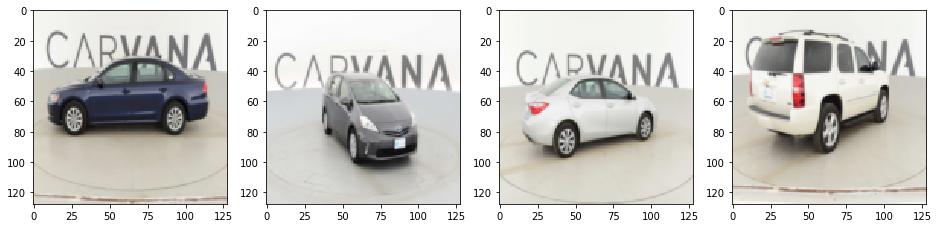

In [27]:
img = next(test_gen)
fig=plt.figure(figsize=(16, 8))
for i in [1, 2, 3, 4]:
    plt.subplot(1, 4, i)
    plt.imshow(img[i-1]*255.0)

Predict

In [24]:
steps = np.ceil(float(len(testdata)) / float(batch_size)).astype(int)
y_predicted = model.predict_generator(
    test_gen, 
    steps=steps
)

See the result

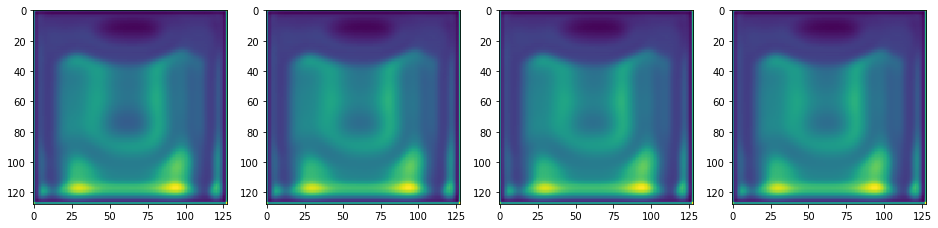

In [25]:
fig=plt.figure(figsize=(16, 8))
for i in [1, 2, 3, 4]:
    y_predict = y_predicted[i-1]
    plt.subplot(1, 4, i)
    plt.imshow(y_predict.reshape(128, 128))

# Working In progress